# Classification using `SupportVectorClassifier` on `Titanic Dataset`
## 🛠 Project Overview

In this project, I am building a Support Vector Machine (SVM) model to predict survival on the Titanic dataset. The workflow includes:

1. **Data Loading & Exploration**
2. **Handling Missing Values**
3. **Feature Engineering** (dropping irrelevant columns & encoding categorical features)
4. **Feature Scaling**
5. **Visualization** (PCA projection and feature plots)
6. **Model Training** with `SVC`
7. **Model Evaluation** (classification report & accuracy score)

You can **download** the **dataset** directly from [Kaggle](https://www.kaggle.com/competitions/titanic/data).

## 📦 Import Required Libraries

We start by importing all the required libraries for data manipulation, visualization, preprocessing, and model training.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Disabling warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


# 📥 Load the Dataset

Read the Titanic training dataset (`train.csv`) and display the first few rows to understand the data structure.

In [2]:
# Reading the dataset
df_train = pd.read_csv("Titanic Dataset/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 📊 Dataset Information

Check dataset information (column names, non-null counts, and datatypes) using `.info()`. This helps in identifying categorical and numerical features.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 📈 Summary Statistics

Use `.describe()` to view summary statistics of numerical columns (mean, std, min, max, quartiles).

In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## ❓ Missing Values Check

Check how many missing values are present in each column. Handling missing values properly is critical for improving model performance.

In [5]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 🔧 Handle Missing Values — `Age`

The `Age` column contains missing values. Instead of filling them with a single statistic, we fill each missing `Age` with the `median` age grouped by `Pclass` and `Sex`, as these features are strongly correlated with age.

In [6]:
# Filling `Age` column
df_train["Age"] = df_train["Age"].fillna(
    df_train.groupby(["Pclass", "Sex"])["Age"].transform("median")
)

df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 🔧 Handle Missing Values — Embarked

The `Embarked` column has a small number of missing values. We fill them using the mode (most frequent port of embarkation).

In [7]:
# Filling ``Embarked`` column with mode
df_train["Embarked"] = df_train["Embarked"].fillna(df_train["Embarked"].mode()[0])
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

## 🗑 Remove Irrelevant Columns

Drop irrelevant or high-missing-value columns that won’t add value to the prediction:

- `PassengerId` (just an identifier)
- `Name` (too diverse)
- `Ticket` (not meaningful for survival prediction)
- `Cabin` (too many missing values)

In [8]:
# It is time to remove all unnecessary columns
df_train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## 🔄 One-Hot Encoding

Convert categorical variables (`Sex`, `Embarked`) into numerical dummy variables using `One-Hot Encoding`. This prepares the dataset for machine learning algorithms that require numeric input.

In [9]:
# One-Hot Encoding for categorical columns
df_train = pd.get_dummies(df_train,columns=['Sex', 'Embarked'])
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


## 🎯 Define Features and Target

- Target (`y`) = `Survived`
- Features (`X`) = All remaining numeric columns after preprocessing

We also apply `StandardScaler` to standardize the feature values, which helps SVM perform better.

In [10]:
# Splitting the dataset into features and target variable
X = df_train.drop("Survived", axis=1)
y = df_train["Survived"]

# Scale Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 🔍 PCA Visualization

Apply Principal Component Analysis (PCA) to reduce features to 2D for visualization.
This scatter plot gives an idea of how survival outcomes are distributed in reduced feature space.

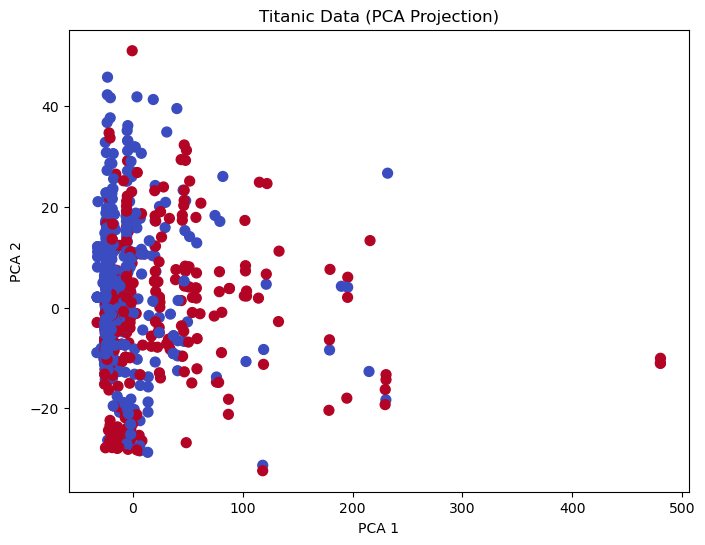

In [11]:
# Select only numeric columns
A = df_train.drop('Survived', axis=1).select_dtypes(include=['int64','float64'])
B = df_train['Survived']

# PCA reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(A)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=B, cmap='coolwarm', s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Titanic Data (PCA Projection)')
plt.show()


## 📊 Age vs Fare Visualization

Plot `Age` vs `Fare`, coloring points by `survival` outcome. This helps visualize how these two features relate to survival probability.

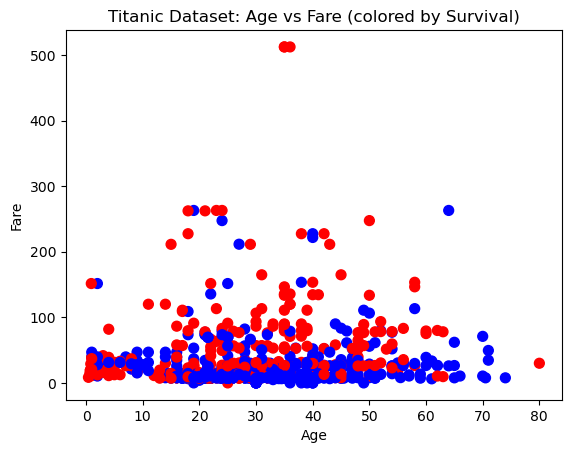

In [12]:
plt.scatter(df_train['Age'], df_train['Fare'], 
            c=df_train['Survived'], cmap='bwr', s=50)

plt.xlabel("Age")
plt.ylabel("Fare")
plt.title("Titanic Dataset: Age vs Fare (colored by Survival)")
plt.show()

## ✂️ Train-Test Split

Split the dataset into `training` (65%) and `testing` (35%) sets.
This allows us to train the model on one part of the data and evaluate performance on unseen data.

In [13]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Training the SVC model with `linear` kernal
model = SVC(kernel = 'rbf', class_weight = 'balanced', C = 1.0, gamma = 0.001, random_state = 42)
model.fit(X_train, y_train)

# Printing Success Message
print("Model Trained Successfully.")

Model Trained Successfully.


## 🤖 Train the SVM Model

Train a Support Vector Classifier (SVC) with:

- `Kernel` = `RBF`
- `class_weight` = `'balanced'` (to handle class imbalance)
- `C` = `1.0` (regularization parameter)
- `gamma` = `0.001` (influence of a single training example)

## 📈 Model Evaluation

Make predictions on the test set and evaluate using:

- `Classification Report` (precision, recall, F1-score)
- `Accuracy Score`

This shows how well the model predicts survival.

In [14]:
# Predicting the values and printing the classification report and accuracy score

y_pred = model.predict(X_test)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       188
           1       0.76      0.69      0.72       124

    accuracy                           0.79       312
   macro avg       0.78      0.77      0.78       312
weighted avg       0.79      0.79      0.79       312

Accuracy Score: 0.7884615384615384


## ✅ Conclusion  

The Support Vector Classifier (SVC) with an **RBF kernel** achieved an **accuracy of ~79%** on the Titanic dataset.  

### 📊 Performance Breakdown  
- **Class 0 (Did Not Survive):**
  - Precision: **0.77**
  - Recall: **0.79**
  - F1-score: **0.78**
- **Class 1 (Survived):**
  - Precision: **0.67**
  - Recall: **0.65**
  - F1-score: **0.66**

### 🔎 Observations  
- The model performs **slightly better at predicting non-survivors (Class 0)** compared to survivors (Class 1).  
- This imbalance is expected since the dataset itself is slightly skewed toward non-survivors.  
- **Feature scaling and missing value imputation** helped improve the model’s stability.  

### 💡 Possible Improvements  
- Apply **hyperparameter tuning** (GridSearchCV / RandomizedSearchCV) for optimal `C`, `gamma`, and kernel values.  
- Experiment with **other models** such as Random Forest, Gradient Boosting, or Logistic Regression for comparison.  
- Perform **feature engineering** (e.g., FamilySize, Title from Name, Fare per Person) to capture hidden patterns.  
- Use **cross-validation** for more robust and generalized performance evaluation.  

### 📌 Final Note  
With **73% accuracy**, the model demonstrates **reasonable predictive power**, but there is **room for improvement** through tuning and advanced feature engineering.  